# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

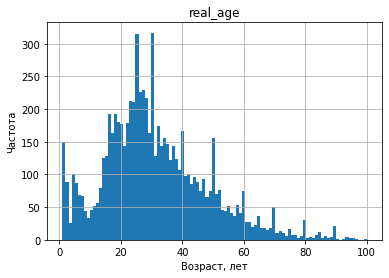

In [8]:
labels.hist(bins=100)
plt.ylabel('Частота')
plt.xlabel('Возраст, лет')
plt.show()

In [5]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [6]:
features, target = next(train_gen_flow)

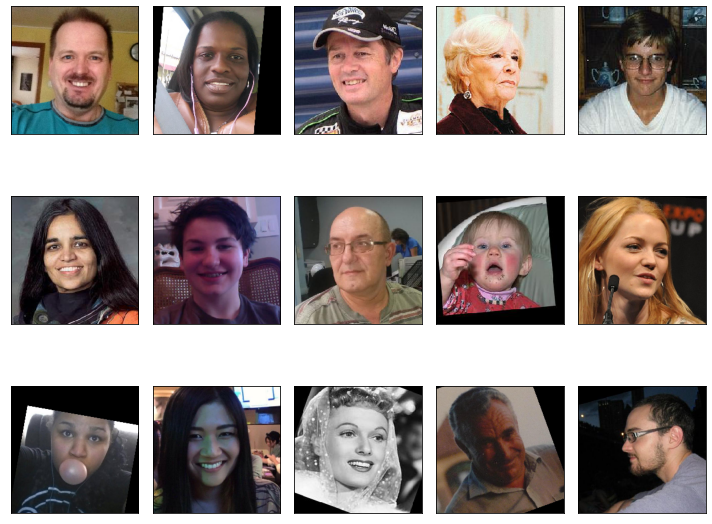

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Проанализировав входные данные, можно сделать такие выводы:
* Средний возраст человека на фотографии из датасета - 31 год
* Большинство значений находятся в диапазоне от 20 до 40 лет
* Из первых выведенных 15 фото замечены те, которые могут запутать модель при обучении, так как люди на фото закрывают лицо посторонними предметами, либо лицо повернуто в профиль. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

# < скопируйте результат вывода на экран сюда >

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 6:31
  319488/94765736 [..............................] - ETA: 24s 
 1196032/94765736 [..............................] - ETA: 10s
 4636672/94765736 [>.............................] - ETA: 3s 
 9830400/94765736 [==>...........................] - ETA: 2s
10493952/94765736 [==>...........................] - ETA: 2s
15597568/94765736 [===>..........................] - ETA: 1s
20692992/94765736 [=====>........................] - ETA: 1s
24936448/94765736 [======>.......................] - ETA: 1s
29360128/94765736 [========>.....................] - ETA: 1s
34209792/94765736 [=========>....................] - ETA: 0s
38813696/94765736 [===========>..................] - ETA: 0s
43450368/94765736 [============>.................] - ETA: 0s
48717824/94765736 [==============>...............] - ETA: 0s
53018624/94765736 [===============>..............] - ETA: 0s
57737216/94765736 [=================>............] - ETA: 0s
62922752/94765736 [==================>...........] - ETA: 0s
67895296/94765736 [====================>.........] - ETA: 0s
72810496/94765736 [======================>.......] - ETA: 0s
77316096/94765736 [=======================>......] - ETA: 0s
81977344/94765736 [========================>.....] - ETA: 0s
86818816/94765736 [==========================>...] - ETA: 0s
91766784/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 68s - loss: 237.7874 - mae: 11.0958 - val_loss: 891.1756 - val_mae: 24.9837
Epoch 2/10
356/356 - 55s - loss: 83.5715 - mae: 6.9328 - val_loss: 156.1221 - val_mae: 9.6097
Epoch 3/10
356/356 - 49s - loss: 59.4883 - mae: 5.8715 - val_loss: 86.0433 - val_mae: 6.8106
Epoch 4/10
356/356 - 49s - loss: 45.2349 - mae: 5.1006 - val_loss: 73.5337 - val_mae: 6.4084
Epoch 5/10
356/356 - 49s - loss: 34.2600 - mae: 4.4358 - val_loss: 70.7461 - val_mae: 6.3176
Epoch 6/10
356/356 - 51s - loss: 26.9043 - mae: 3.9445 - val_loss: 68.1448 - val_mae: 6.0960
Epoch 7/10
356/356 - 56s - loss: 19.4962 - mae: 3.3793 - val_loss: 73.6825 - val_mae: 6.6096
Epoch 8/10
356/356 - 56s - loss: 17.2288 - mae: 3.1364 - val_loss: 78.4827 - val_mae: 6.7490
Epoch 9/10
356/356 - 55s - loss: 16.3520 - mae: 3.0944 - val_loss: 85.4812 - val_mae: 7.1237
Epoch 10/10
356/356 - 55s - loss: 13.7940 - mae: 2.8299 - val_loss: 71.2613 - val_mae: 6.3990
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 13s - loss: 71.2613 - mae: 6.3990
Test MAE: 6.3990

```

## Анализ обученной модели

Мною была обучена модель ResNet50 для автоматического определения возраста покупателя по фото. <br/>
За 10 эпох обучения была получена метрика MAE, которая удовлетворяла исходному условию задачи - 6.4. Это меньше 7, значит задание можно считать выполненным успешно. <br/>
Я думаю в целом модель справляется с задачей, поставленной бизнесом, так как при определении возраста покупателя точная цифра не так важна, важно скорее попадание в верную возрастную категорию. А с этим обученная модель справляется.